# Data Exploration for MP Data

**Author:** Mathieu Gardette

This notebook studies the young basketball players future on the NBA league. Based on 12 stats, the objective is to determine if the players will be relevant in 5 Years. 

In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import recall_score, precision_score, confusion_matrix, f1_score
import seaborn as sns               
import matplotlib.pyplot as plt

from typing import Any

## Functions used

In [32]:
def print_covariance(data: pd.DataFrame, size: tuple[int,int] =(30,30), title: str | None = None):
    """Print the covariance matric graph for the given dataframe.

    Args:
        data (pd.DataFrame): The dataframe to work on
        size (tuple[int,int], optional): Size of the figure to show. Defaults to (30,30).
        title (str | None, optional): Graph title. Defaults to None.
    """
    cov_mat = data.cov()
    plt.figure(figsize=size)
    sns.set_theme(font_scale=1.5)
    hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 20},
                 yticklabels=data.columns,
                 xticklabels=data.columns)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [33]:
def test_classifier(classifier: Any, X: pd.DataFrame, y: pd.DataFrame, folds: int = 3) -> None:
    """ Test the given classifier through a stratified K-Fold defaulting to 3 folds.

    Args:
        classifier (Any): A classifier instance to test 
        X (pd.DataFrame): The feature dataframe
        y (pd.DataFrame): The labels
        folds (int, optional): The number of folds to split the dataset into. Defaults to 3.  
            See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
    """

    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

    kf = StratifiedKFold(n_splits=3,random_state=50,shuffle=True)

    total_recall = 0
    ttl_precision = 0
    total_f1 = 0
    
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    
        y_train = y.loc[train_index].to_numpy()
        X_train = X.loc[train_index.tolist(),:]
        
        y_test = y.loc[test_index].to_numpy()
        X_test = X.loc[test_index.tolist(),:]
    
        classifier.fit(X_train, y_train)
        predicted = classifier.predict(X_test)
    
        recall = recall_score(y_pred=predicted, y_true=y_test)
        precision = precision_score(y_pred=predicted, y_true=y_test)
        f1 = f1_score(y_pred=predicted, y_true=y_test)
    
        total_recall += recall
        ttl_precision += precision
        total_f1 += f1
        
    print(f"\nStep {i+1}: Avg Recall {total_recall/(i+1):.3f}")
    print(f"Step {i+1}: Avg Precision {ttl_precision/(i+1):.3f}")
    print(f"Step {i+1}: Avg F1 {total_f1/(i+1):.3f}")

In [34]:
def print_confusion_matrix(y: np.array, predicted: np.array, title: str = "Confusion Matrix") -> None:
    cf_matrix = confusion_matrix(y, predicted)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = cf_matrix.flatten()
    group_percentages = ["{0:.2%}".format(value) for value in
    cf_matrix.flatten()/np.sum(cf_matrix)]
    cov_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    cov_labels = np.asarray(cov_labels).reshape(2,2)
    plt.title(title)
    sns.heatmap(cf_matrix, annot=cov_labels, fmt='', cmap='Blues', cbar=False)

## Data Loading and Data Cleaning

In [35]:
df = pd.read_csv("../data/nba_logreg.csv")

As shown below by the player who played the most and the player who played the least, the dataset is not scaled by the number of minutes played.

In [36]:
df.loc[(df.MIN == df["MIN"].max()) | (df.MIN == df["MIN"].min())]

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
809,Demetris Nichols,14,3.1,1.1,0.4,1.6,26.1,0.2,0.9,23.1,...,0.0,0.0,0.0,0.4,0.4,0.1,0.0,0.2,0.3,0.0
1190,Damon Stoudamire,70,40.9,19.0,6.9,16.1,42.6,1.9,4.8,39.5,...,4.2,79.7,0.8,3.2,4.0,9.3,1.4,0.3,3.8,1.0


The following graph shows us the more a player is included in games, the more likely he will be playing after five years. This is of course not the reason a player gets picked at the beginning but a consequence of all the other stats he got.

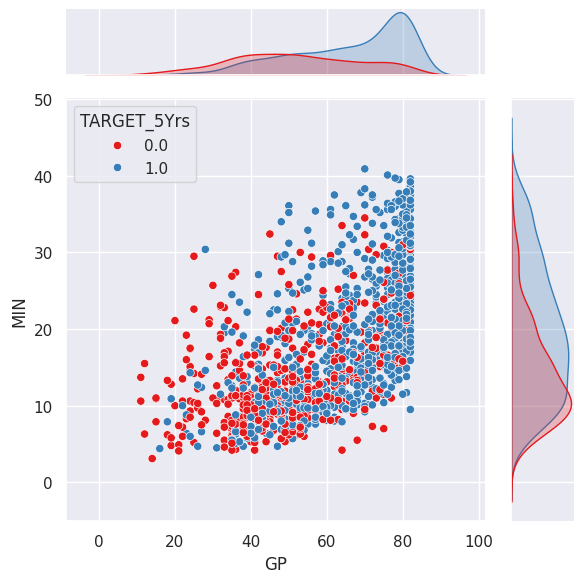

In [37]:
sns.jointplot(x="GP", y="MIN", data=df, hue="TARGET_5Yrs", palette="Set1")
plt.tight_layout()

## Data Pre-processing

We have to set a foot of equality between the players. Some have been playing for longer than others as the MIN column shows. So we're watching the players performance pro rata their minutes played. So we're each value dividing by the time they played to begin with.

In [38]:
features = df.loc[:,"PTS":"TOV"].div(df["GP"], axis=0)
labels = df['TARGET_5Yrs'].astype(int)
names = df.iloc[:,1]

We must choose a strategy to fill the Nan, here giving a 0 is very penalizing, so we will give the mean to the Nan value. At worst, we will end up with an outlier.

In [39]:
features.fillna(features.mean(), inplace=True)

Here I chose the Standard Scaler over the MinMax Scaler to be able to process the correlation features

In [40]:
fitted_features = pd.DataFrame(StandardScaler().fit_transform(features), columns=features.columns)

## Feature importance

We will evaluate the importance of features based 

In [41]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.66)

forest = RandomForestClassifier(random_state=42)
_ = forest.fit(X_train, y_train)

In [42]:
features_importance = pd.DataFrame(data=forest.feature_importances_, index=features.columns, columns=["value"]).T
features_importance

,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
value,0.049752,0.050918,0.053067,0.11116,0.029062,0.045364,0.04834,0.058325,0.055541,0.114484,0.056834,0.061552,0.051327,0.056336,0.050577,0.052098,0.055263


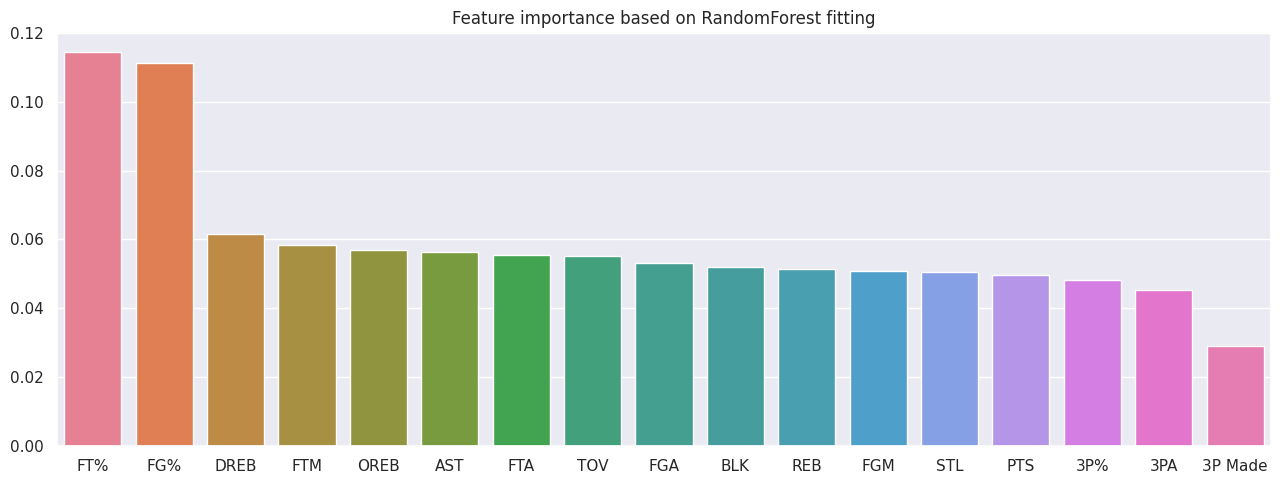

In [43]:
plt.figure(figsize=(13,5))
sns.barplot(features_importance.sort_values(["value"], ascending=False, axis=1))
sns.set_theme(style="darkgrid")
plt.title("Feature importance based on RandomForest fitting")
plt.tight_layout()

Based on the RandomForest fitting, we can see the most important features are the field goal percentage (FG%) and the field throw percents (FT%). We will keep them when checking the correlation later

## Dimensionality Reduction

The objective is to remove highly correlated features to avoid useless data in our model (>60%), thus avoiding the "Curse of Dimensionality" 

From a basketball perspective, the following features are explaining the same thing and, as shown below, are heavily correlated thus we can remove them, they are redundant:

- FGM and FGA -> FG%
- 3P Made & 3PA -> 3P%
- FTM & FTA -> FT%
- REB -> OREB + DREB


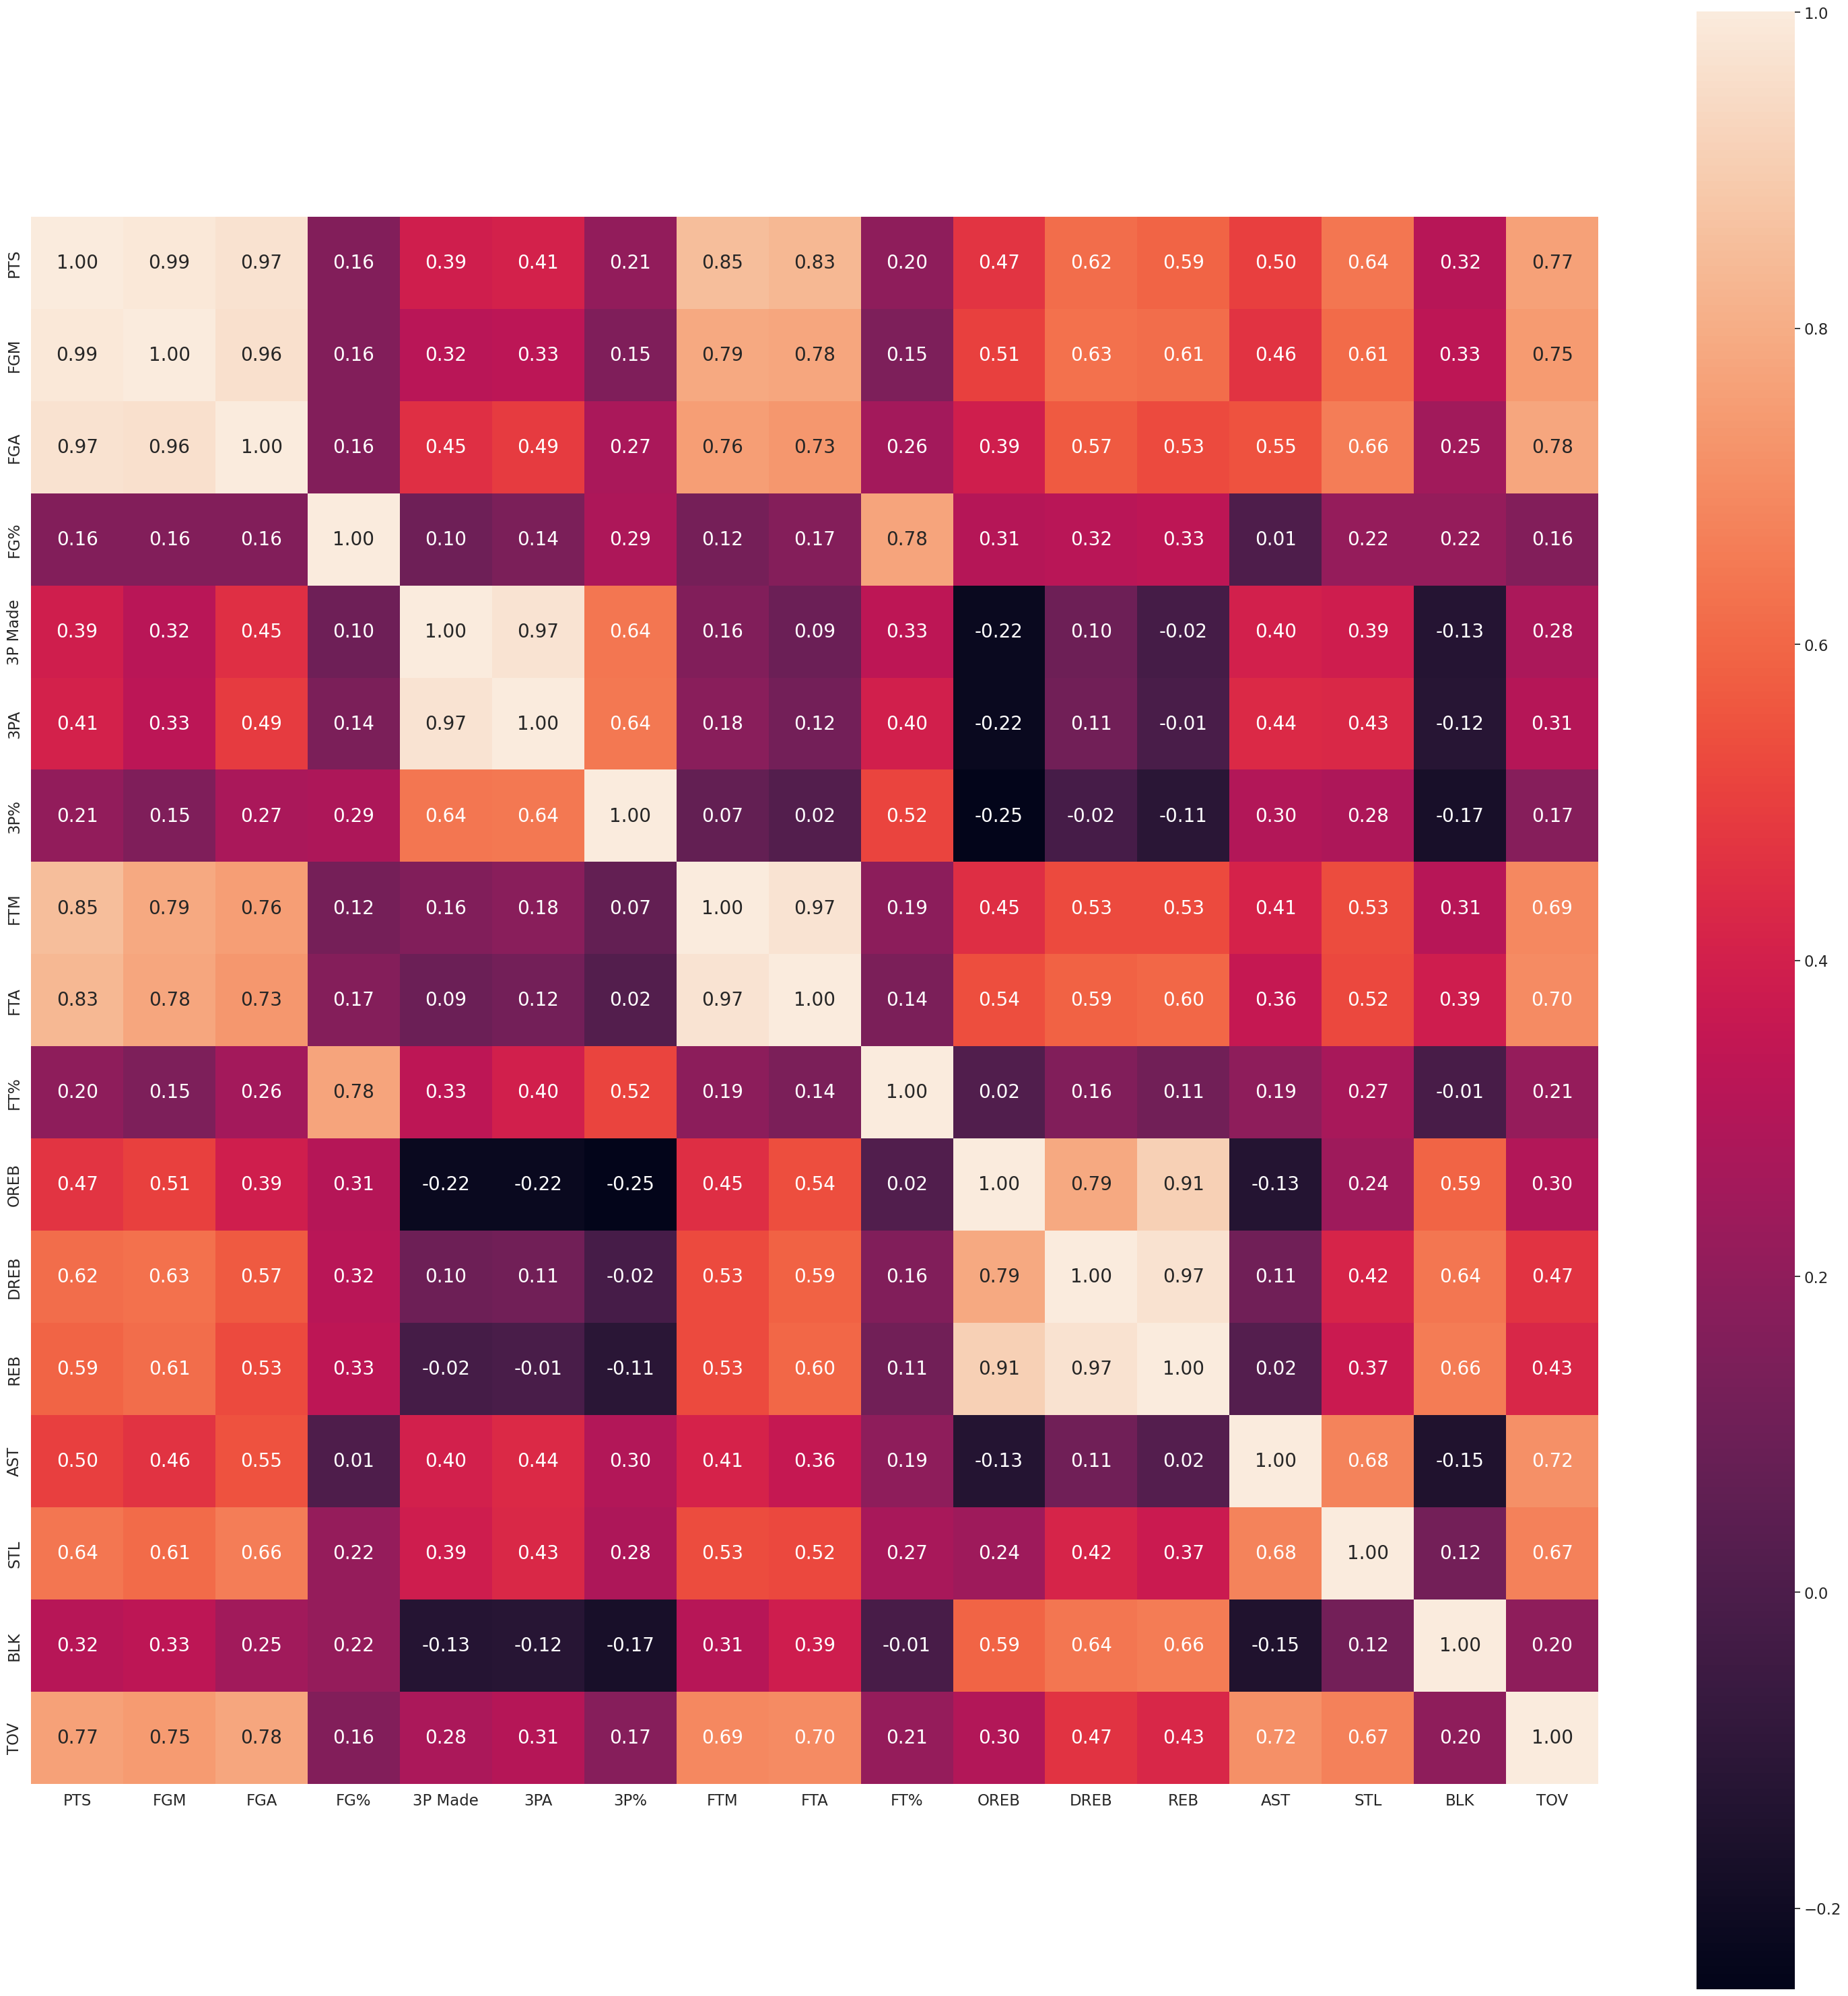

In [44]:
print_covariance(fitted_features)

In [48]:
cleaned_features = fitted_features.drop(columns=["FGM", "FGA", "3P%", "3PA", "FTM", "FT%", "REB", "DREB", "PTS", "TOV", "STL"])

As a rule of thumb, we consider a high covariance a covariance going over 60%. This means the values are following a polynomial relationship and having one, the other can be predicted. Thus, we remove them.  

Here, this includes:
* DREB which correlates at 60% with blocks (BLK) and 71% with OREB, 
* The number of points made (PTS) which correlates with the free throws attempts at 57% and most importantly with the field goals attempts (FGA) at 86%.
* The turnover (TOV) with the number of steals (STL), assists (AST) free throws (FTA/FTM), field goals (FGA/FGM) and points (PTS) 
* The number of assists (AST) with the number of steals (STL)

This provides a simplified dataset for the classifier to work on, avoiding overfitting and fitting times.  
As we can see below, the dataset is now simplified and should not overfit

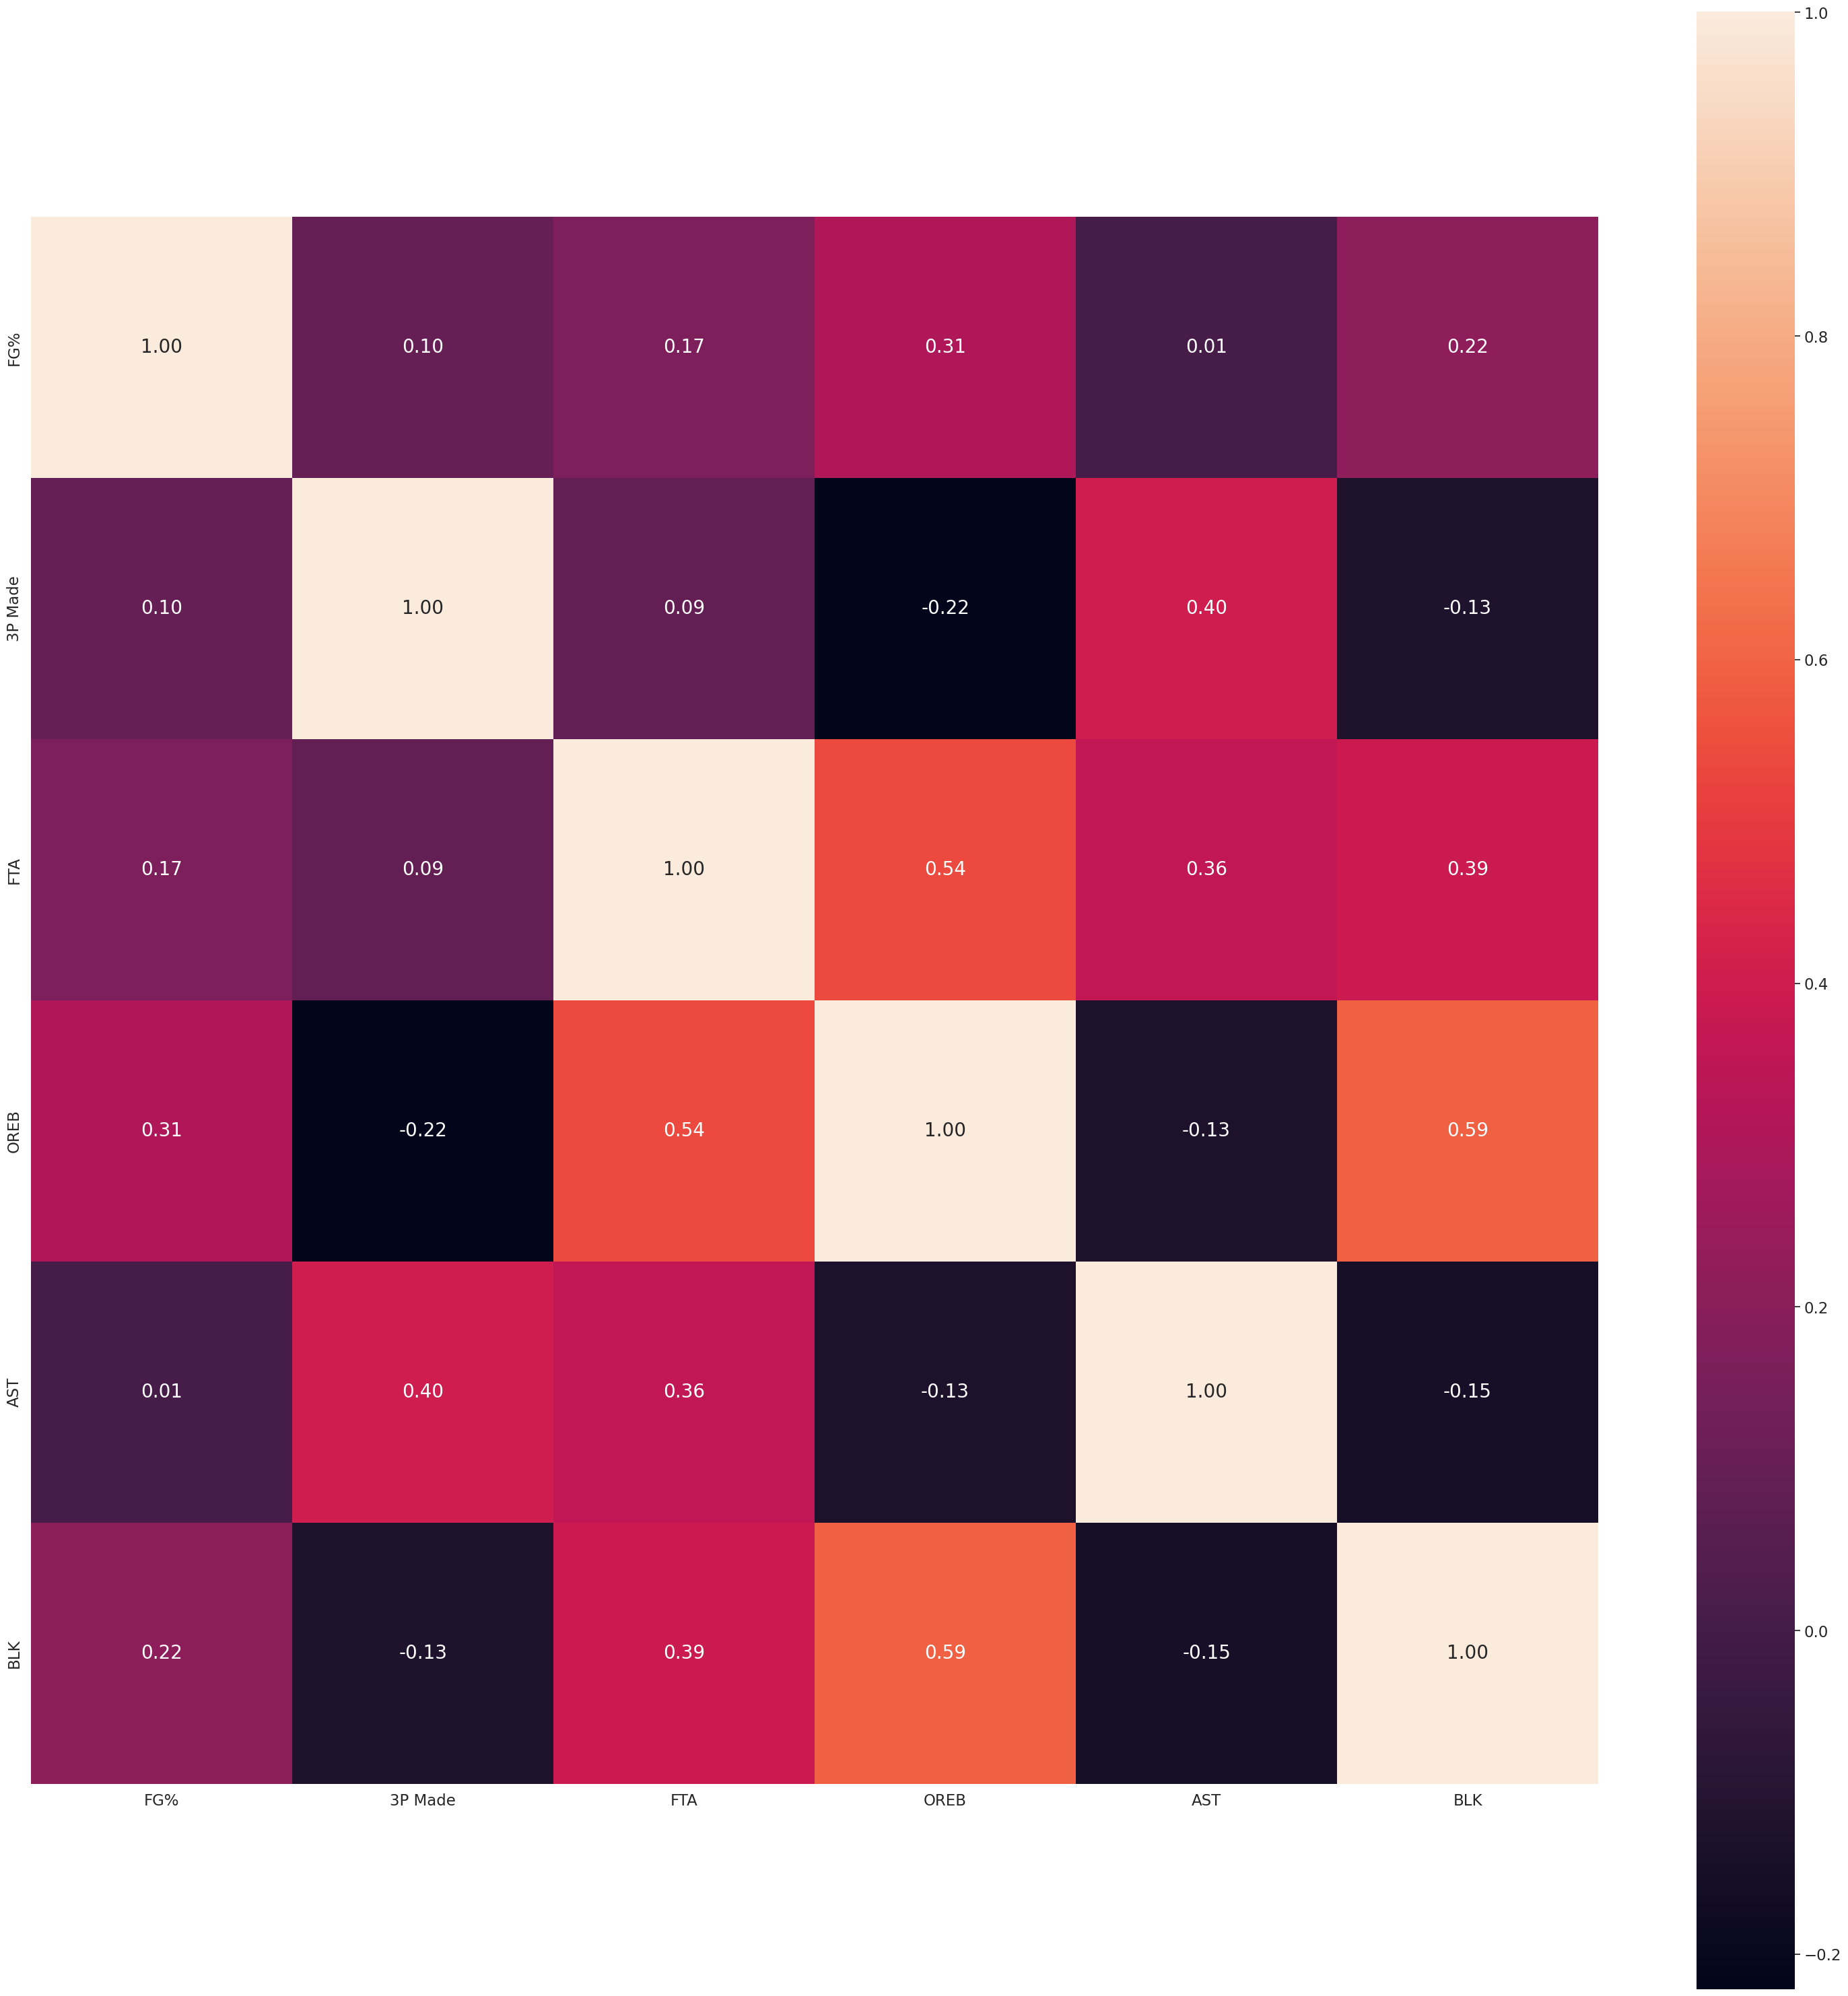

In [51]:
print_covariance(cleaned_features)

## Checking for ouliners

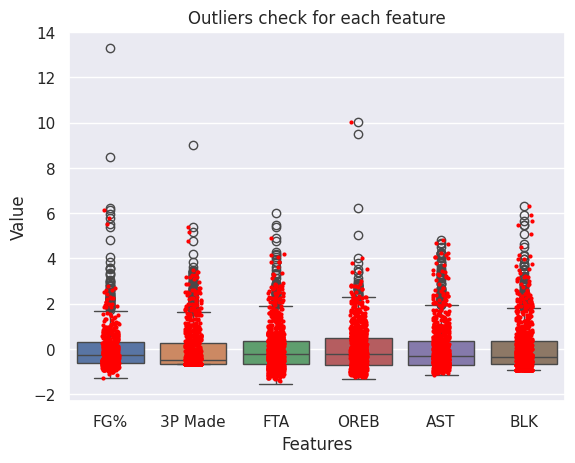

In [52]:
sns.set_theme(style="darkgrid")
sns.boxplot(cleaned_features)
sns.stripplot(data=cleaned_features.loc[labels.values==1], color='red', size=3)

plt.title('Outliers check for each feature')
plt.xlabel('Features')
plt.ylabel('Value')
plt.show()

Conclusion: We can see that there is no hard limit which shows a clear limit between a player that passed the 5 year limit and one who didn't. Then, the answer is to be found in the relationship between the various features.

## Classifier choice

In this part, we will be choosing the best classifier for our model. We are going to study a range of models using the same technique:  
A Stratified KFold on a Test set of $\frac {2}{3}$ of the dataset.  
The stratification will keep the global label balance between each class in each fold, since our dataset contains approximately $60\%$ of false target class and thus $40\%$ of true

The binary classifier we're going to use are the following:
* Stochastic Gradient Descent Classifier, fast but non optimal (can end in local minimas)
* Random Forest Classifier, decent results
* State Vector Classifier, (and its scalable conterpart, LinearSVC)


In [53]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_features, labels, train_size=0.66, random_state=42 )

In [54]:
sgd = SGDClassifier()
test_classifier(classifier=sgd, X=X_train, y=y_train)


Step 3: Avg Recall 0.543
Step 3: Avg Precision 0.734
Step 3: Avg F1 0.619


In [55]:

rfe = RandomForestClassifier()
test_classifier(classifier=rfe, X=X_train, y=y_train)



Step 3: Avg Recall 0.771
Step 3: Avg Precision 0.693
Step 3: Avg F1 0.730


In [56]:
lsvc = LinearSVC()
test_classifier(classifier=lsvc, X=X_train, y=y_train)


Step 3: Avg Recall 0.897
Step 3: Avg Precision 0.674
Step 3: Avg F1 0.769


In [57]:
svm = SVC()
test_classifier(svm,  X=X_train, y=y_train)


Step 3: Avg Recall 0.835
Step 3: Avg Precision 0.680
Step 3: Avg F1 0.750


Here, the recall represents the percentage of real positives correctly classified, where the precision represent the percentage of predicted positives correctly classified.  
The arbitration between the two are based on what the client wants. Does he want us to not miss any potential player, then we would use the recall, or do we want to avoid false positive, where we would use the precision.  
As I do not know, we will try to reach a good balance between recall and precision, materialized by the F1 score, which is the harmonic mean of the two (see below).  
This implies that the low values of either recall or precision will heavily penalize the score.

$F_1 = 2* \frac {precision * recall}{precision + recall}$

In [58]:
labels.value_counts()

TARGET_5Yrs
1    831
0    509
Name: count, dtype: int64

Conclusion: We will try to optimize the Linear SVC using a GridSearch and a cross validation, which gives the best recall and $F_1$ score  
We added the class weight parameter to counter balance the unbalanced dataset. 61% of 1 = $\frac {1}{0.61} = 1.64$ and 39% of 0 = $\frac {1}{0.39} = 2.56$

In [59]:
parameters_dictionary = {'C':[0.001, 1, 10],
                         'loss':['hinge', 'squared_hinge'],
                         'class_weight': [{0:2.56, 1:1.64}, {0:1, 1:1}, {0:1.64, 1:2.56}]}

lsvc = LinearSVC(max_iter=100000)

grid_search = GridSearchCV(lsvc, 
                           parameters_dictionary, 
                           scoring = 'f1',
                           return_train_score=True, 
                           cv = 5,
                           verbose = 1)
grid_search.fit(X_train, y_train)

print('The best model was:', grid_search.best_estimator_)
print('The best parameter values were:', grid_search.best_params_)
print('The best f1-score was:', grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/manitou/.cache/pypoetry/virtualenvs/test-data-science-rT2C3_WW-py3.12/lib64/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/manitou/.cache/pypoetry/virtualenvs/test-data-science-rT2C3_WW-py3.12/lib64/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/manitou/.cache/pypoetry/virtualenvs/test-data-science-rT2C3_WW-py3.12/lib64/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/manitou/.cache/pypoetry/virtualenvs/test-data-science-rT2C3_WW-py3.12/lib64/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


The best model was: LinearSVC(C=0.001, class_weight={0: 1.64, 1: 2.56}, loss='hinge',
          max_iter=100000)
The best parameter values were: {'C': 0.001, 'class_weight': {0: 1.64, 1: 2.56}, 'loss': 'hinge'}
The best f1-score was: 0.7707598203487617


In [60]:
lsvc = LinearSVC(C=1, loss='hinge', max_iter=100000, class_weight='balanced')
_=lsvc.fit(X_train, y_train)

In [61]:
predicted = lsvc.predict(X=X_test)

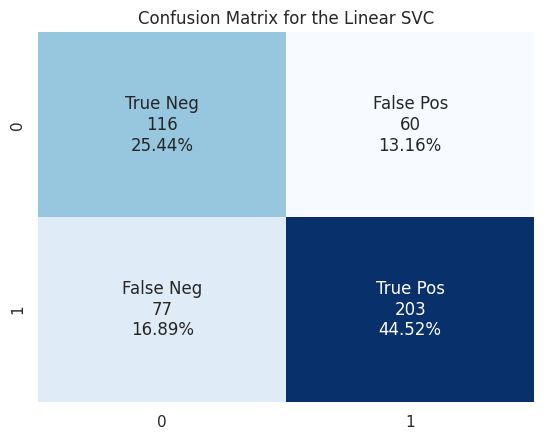

In [62]:
print_confusion_matrix(y_test, predicted, "Confusion Matrix for the Linear SVC")

In [63]:
recall= recall_score(y_pred=predicted, y_true=y_test)
precision = precision_score(y_pred=predicted, y_true=y_test)
f1 = f1_score(y_pred=predicted, y_true=y_test)

print(f"\nRecall {recall:.3f}")
print(f"Precision {precision:.3f}")
print(f"F1 {f1:.3f}")


Recall 0.725
Precision 0.772
F1 0.748


In [84]:
X =pd.DataFrame.from_dict({
  "games_played": 60,
  "minutes_played": 17.0,
  "points": 7,
  "fieldgoals_made": 3,
  "fieldgoals_attempts": 8,
  "fieldgoals_percents": 37.5,
  "threepoints_made": 1,
  "threepoints_attempts": 4,
  "threepoints_percents": 25.0,
  "freethrow_made": 0,
  "freethrow_attempts": 1,
  "freethrow_percentage": 0.0,
  "offensive_rebounds": 1,
  "defensive_rebounds": 3,
  "rebounds": 4,
  "assists": 1,
  "steals": 0,
  "blocks": 0,
  "turnovers": 2
},orient='index').T
X

,games_played,minutes_played,points,fieldgoals_made,fieldgoals_attempts,fieldgoals_percents,threepoints_made,threepoints_attempts,threepoints_percents,freethrow_made,freethrow_attempts,freethrow_percentage,offensive_rebounds,defensive_rebounds,rebounds,assists,steals,blocks,turnovers
0,60.0,17.0,7.0,3.0,8.0,37.5,1.0,4.0,25.0,0.0,1.0,0.0,1.0,3.0,4.0,1.0,0.0,0.0,2.0


In [86]:
X.loc[:,["fieldgoals_percents", "threepoints_made", "freethrow_attempts","offensive_rebounds", "assists", "blocks"]]

,fieldgoals_percents,threepoints_made,freethrow_attempts,offensive_rebounds,assists,blocks
0,37.5,1.0,1.0,1.0,1.0,0.0


In [74]:
lsvc2 = LinearSVC()
lsvc2.set_params(params=params)
predicted2 = lsvc2.predict(X=X_test)

ValueError: Invalid parameter 'params' for estimator LinearSVC(). Valid parameters are: ['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'].

In [ ]:
print_confusion_matrix(y_test, predicted2, "Confusion Matrix for the Linear SVC2")

In [ ]:
recall= recall_score(y_pred=predicted2, y_true=y_test)
precision = precision_score(y_pred=predicted2, y_true=y_test)
f1 = f1_score(y_pred=predicted2, y_true=y_test)

print(f"\nRecall {recall:.3f}")
print(f"Precision {precision:.3f}")
print(f"F1 {f1:.3f}")

## Conclusion

The Linear SVM is the best, and most scalable model we could optimize.  
We had to get rid of some features which were not interesting because of low importance or because they were correlated between them.
The dataset was unbalanced and needed tweaking the classifier class_weight.  
The metric chosen, the f1 score, to test our classifier is a middle ground for us to get something that isn't scoring only the positive predictions but also the negative ones.

### Improvments to consider

* We could try to improve the classifier by having a business partner whom is knowledgeable about basketball so we could get easier insights in the data.
* Try to combine different features by doing feature engineering.
* Try to synthesize more data to balance out the dataset  
